In [1]:
import pandas as pd
import gzip
import json
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import os
import numpy as np


In [2]:
# import the help class 
from helper import *

In [3]:
# Function to load and explore a dataset 
def load_and_explore(dataset_name, set_path, set_file):
    path = f'{dataset_name}/{set_path}/{set_file}.json.gz'
    with gzip.open(path, 'rt') as file:
        # Load each line separately and concatenate
        data = [json.loads(line) for line in file]
    return data

In [4]:
# Load non-vpn2016 training set
non_vpn2016_train_data = load_and_explore('non-vpn2016', '2_training_set', '2_training_set')
non_vpn2016_train_df = pd.DataFrame(non_vpn2016_train_data)


In [5]:

# Display a few entries to understand the structure
print(non_vpn2016_train_df[:5])

   pr                                 rev_intervals_ccnt  rev_pld_max  \
0  17   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]            0   
1   6  [0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0]            0   
2  17   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]            0   
3   6  [0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0]            0   
4   6  [12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]         1350   

   dst_port  num_pkts_in                                           pld_ccnt  \
0      5355            0   [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
1       443           13  [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2      5355            0   [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3       443           13  [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
4     13000           13   [7, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 5]   

                            rev_hdr_ccnt  \
0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  

In [6]:
# Define function to create submissions
def do_submit(clf, test_set, scaler, class_label_pair, filepath):
    Xtest, ids = get_submission_data(test_set)
    X_test_scaled = scaler.transform(Xtest)
    print("Predicting on {} ...".format(test_set.split('/')[-1]))
    predictions = clf.predict(X_test_scaled)
    make_submission(predictions, ids, class_label_pair, filepath)   

In [7]:
def train_and_evaluate(training_set_foldername, training_anno_file, test_set_foldername, save_dir, anno_level):
    
     # Get training data
    print("\nLoading training set ...")
    Xtrain, ytrain, class_label_pair, Xtrain_ids = get_training_data(training_set_foldername, training_anno_file)
    
    # Split validation set from training data
    X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain,
                                                test_size=0.2, 
                                                random_state=42,
                                                stratify=ytrain)


   # Get name of each class to display in confusion matrix
    class_names = list(sorted(class_label_pair.keys()))

    # Preprocess the data
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Train a Model
    print("Training the model ...")


    # Choose a model (here we use Logistic Regression)
    model = LogisticRegression(random_state=42, max_iter=1000)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate on the validation set
    y_val_pred = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Annotation Level: {anno_level}')
    print(f'Validation Accuracy: {accuracy}')

    # Load and preprocess the non-vpn2016 test set
    print("Loading submission set ...")
    test_feature_names, ids_test, X_test, _, _, = read_dataset(test_set_foldername)

    # Convert np.array to dataframe for easy manipulations
    test_df = pd.DataFrame(data=X_test,
                           index=[i for i in range(X_test.shape[0])],
                           columns=test_feature_names)
    
    # Print Confusion Matrix
    ypred = model.predict(X_val_scaled)

    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plot_confusion_matrix(directory=save_dir, y_true=y_val, y_pred=ypred, 
                        classes=class_names, 
                        normalize=False)

    # Get np.array for Xtest
    X_test = test_df.values

    # Preprocess the test set
    X_test_scaled = scaler.transform(X_test)

    # Make predictions on the test set
    y_test_pred = model.predict(X_test_scaled)

    # Prepare predictions for submission
    #submission = [{'id': test_id, 'prediction': class_label_pair[pred]} for test_id, pred in zip(ids_test, y_test_pred)]

    do_submit(model, test_set_foldername, scaler, class_label_pair, save_dir+"/submission_test-std-"+anno_level+".json")
    # Save submission file
   


# Train and evaluate models for each level of granularity

In [8]:
# using 2_training_set 
training_set_foldername = "./non-vpn2016/2_training_set"

# test set foldername
test_set_foldername = "./non-vpn2016/1_test-std_set"

# 1) using top-level annotation 


Loading training set ...

Loading training set ...
Reading 2_training_set.json.gz
Training data is not empty.
Training the model ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Annotation Level: top
Validation Accuracy: 0.699652844008698
Loading submission set ...
Reading 1_test-std_set.json.gz
F1: 			0.59258
mAP: 			0.20274
Confusion matrix is saved as ./results/top/CM.png

Loading submission set ...
Reading 1_test-std_set.json.gz
Predicting on 1_test-std_set ...
Submission file is created as ./results/top/submission_test-std-top.json



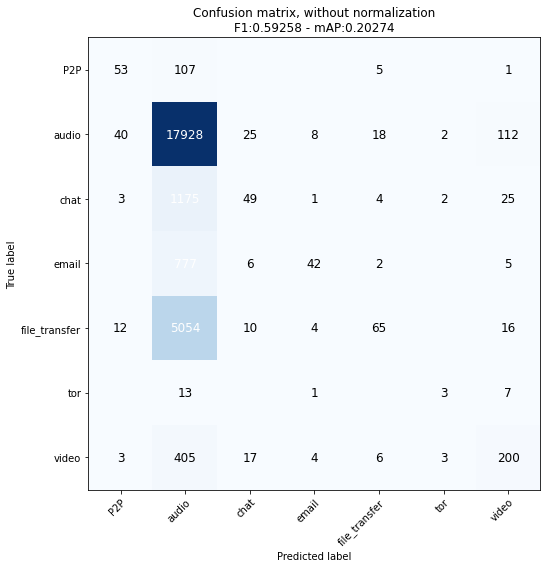

In [9]:
# using top-level annotation 
training_anno_file = "./non-vpn2016/2_training_annotations/2_training_anno_top.json.gz"
anno_level="top"
save_dir="./non-vpn2016/results/"+anno_level
train_and_evaluate(training_set_foldername, training_anno_file, test_set_foldername, save_dir, anno_level)

# 2) using mid-level annotation


Loading training set ...

Loading training set ...
Reading 2_training_set.json.gz
Training data is not empty.
Training the model ...
Annotation Level: mid
Validation Accuracy: 0.42974859802388127
Loading submission set ...
Reading 1_test-std_set.json.gz
F1: 			0.35777
mAP: 			0.16028
Confusion matrix is saved as ./results/mid/CM.png

Loading submission set ...
Reading 1_test-std_set.json.gz
Predicting on 1_test-std_set ...
Submission file is created as ./results/mid/submission_test-std-mid.json



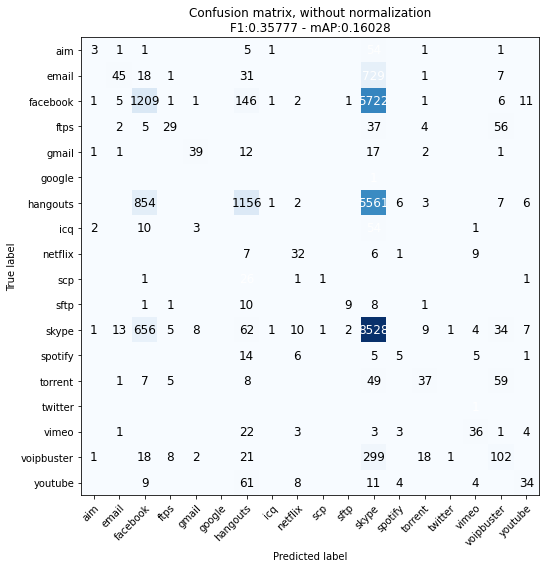

In [10]:
# using mid-level annotation 
training_anno_file = "./non-vpn2016/2_training_annotations/2_training_anno_mid.json.gz"
anno_level="mid"
save_dir="./non-vpn2016/results/"+anno_level
train_and_evaluate(training_set_foldername, training_anno_file, test_set_foldername, save_dir, anno_level)

# 3) using fine-level annotation


Loading training set ...

Loading training set ...
Reading 2_training_set.json.gz
Training data is not empty.
Training the model ...
Annotation Level: fine
Validation Accuracy: 0.3128600312821882
Loading submission set ...
Reading 1_test-std_set.json.gz
F1: 			0.23444
mAP: 			0.11665
Confusion matrix is saved as ./results/fine/CM.png

Loading submission set ...
Reading 1_test-std_set.json.gz
Predicting on 1_test-std_set ...
Submission file is created as ./results/fine/submission_test-std-fine.json



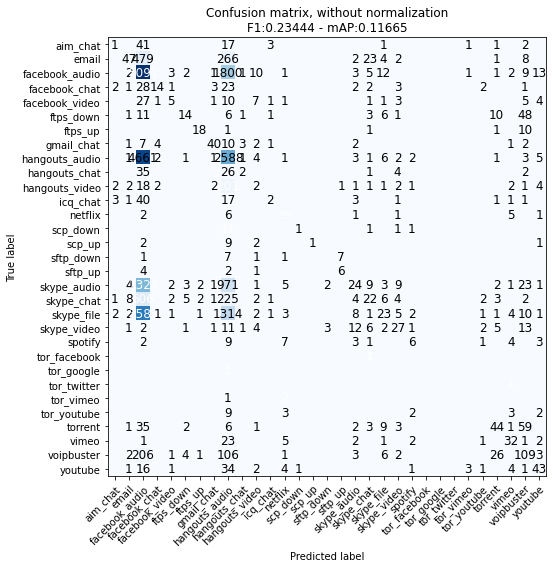

In [11]:
# using fine-level annotation 
training_anno_file = "./non-vpn2016/2_training_annotations/2_training_anno_fine.json.gz"
anno_level="fine"
save_dir="./non-vpn2016/results/"+anno_level
train_and_evaluate(training_set_foldername, training_anno_file, test_set_foldername, save_dir, anno_level)